In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Backpropagation Demo

In this demo, we will create a simple neural network with a single hidden layer and train it to classify by identity, gender, and expression.

In [2]:
from numpy import *
from IPython.html.widgets import *
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Load the dataset and write the routine to perform preprocessing (PCA).

In [3]:
import pickle
dataset=pickle.load(open('cafe.pkl','r')) # or 'pofa.pkl' for POFA

from numpy.linalg import svd
def preprocess(data, n_components=10):
    X=data.copy()
    X_mean=X.mean(axis=0,keepdims=True)
    X_std =X.std(axis=0,keepdims=True)
    X-=X_mean
    X/=X_std
    _,s,V=svd(X,compute_uv=True, full_matrices=False)    
    return dot(X, V[:n_components].T), X_mean, X_std, V


Now, let's define the neural network class.

In [10]:
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split
from numpy.random import random_sample

class NeuralNetwork(object):
    def _activation(self, x):
        """ Funny tanh function. """
        z = x*2/3
        y = (exp(z) - exp(-z)) / (exp(z) + exp(-z))
        return 1.7159*y
    
    def _da(self, x):
        return (1.7159 - multiply(x, x) / 1.7159) * 2/3
    
    def feed_forward(self, X):
        """From the input X, calculate the activations at the hidden layer and the output layer."""
        Z      = self._activation(dot(c_[X, ones((X.shape[0], 1))], self.W_hidden))
        return   self._activation(dot(c_[Z, ones((X.shape[0], 1))], self.W_output)), Z
                                        
    def back_propagate(self, inputs, hidden, output, errors):
        """Back-propagate the errors and update the weights."""
        d_output = self._da(output) * errors
        d_hidden = self._da(hidden) * dot(d_output, self.W_output[:-1].T)
        
        n_samples = inputs.shape[0]
        bias = ones((n_samples, 1))
        # Update momentum and weights
        self.V_output = self.output_learning_rate * dot(c_[hidden, bias].T, d_output) / n_samples + \
                        self.momentum_learning_rate * self.V_output
        self.W_output+= self.V_output
        
        self.V_hidden = self.hidden_learning_rate * dot(c_[inputs, bias].T, d_hidden) / n_samples + \
                        self.momentum_learning_rate * self.V_hidden
        self.W_hidden+= self.V_hidden 
    
    def train(self, data, targets, epochs = 100, n_input = 10, n_hidden = 40, 
            hidden_learning_rate = 0.1, output_learning_rate = 0.1, momentum_learning_rate = 0.9,          
            test_size=0.2, cv=3):
        """Initialize the network and start training."""

        # Initialize variables
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.hidden_learning_rate = hidden_learning_rate
        self.output_learning_rate = output_learning_rate
        self.momentum_learning_rate = momentum_learning_rate
        self.targets = targets
        
        self.n_output = len(unique(targets))
        self.V_hidden = zeros((self.n_input + 1, self.n_hidden))
        self.W_hidden = random_sample(self.V_hidden.shape)
        self.V_output = zeros((self.n_hidden + 1, self.n_output))
        self.W_output = random_sample(self.V_output.shape)
        
        # Preprocess the data
        disp('Preprocessing %d samples' % data.shape[0])
        X, X_mean, X_std, V = preprocess(data, n_components=self.n_input)
        self.X = X
        self.X_mean = X_mean
        self.X_std = X_std
        self.V = V

        # Start the training
        disp('Starting network training')
        rmse=zeros((epochs,2))
        cerr=zeros((epochs,2))
        for t in arange(epochs):
            # Reshuffle
            X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=test_size, random_state=0)
            
            # Test then Train, since we'll use the training errors
            for i, (inputs, y) in enumerate([[X_test, y_test], [X_train, y_train]]):
                outputs, hidden = self.feed_forward(inputs)
                target=ones(outputs.shape)*(-1.0)
                target[arange(target.shape[0]),y-1]=1.0
                errors = target - outputs
                rmse[t, i] = sqrt((errors**2).mean())  # RMSE
                cerr[t, i] = (y == argmax(outputs,axis=1)).mean()
            
            yield rmse, cerr, t, epochs
            
            # Update weights using backpropagation
            self.back_propagate(inputs, hidden, outputs, errors)

    def predict(self, n):
        """Returns the prediction and the reconstruction for the sample n."""
        outputs, hidden = self.feed_forward(self.X[n:n+1])
        return argmax(outputs) + 1, dot(self.X[n:n+1], self.V[:self.n_input]) * self.X_std + self.X_mean

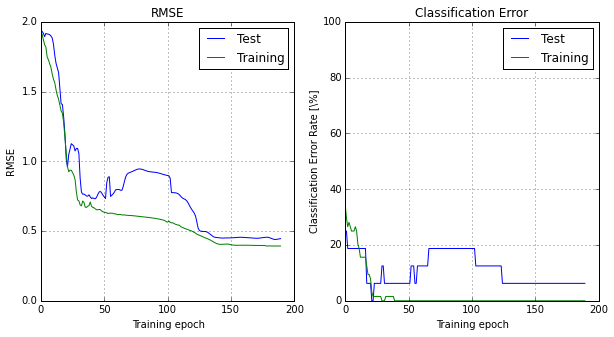

In [11]:
def plot_training(axs, rmse, cerr, t, epochs):
    """Draw the plot to the specified axis."""
    axs[0].set_title("RMSE")
    axs[0].set_xlabel("Training epoch")
    axs[0].set_ylabel("RMSE")
    axs[0].grid()

    axs[0].plot(arange(t), rmse[:t])
    axs[0].set_xlim([0, epochs])
    axs[0].set_ylim([0, 2.0])
    axs[0].legend(['Test', 'Training'], loc="best")

    axs[1].set_title("Classification Error")
    axs[1].set_xlabel("Training epoch")
    axs[1].set_ylabel("Classification Error Rate [\%]")
    axs[1].grid()

    axs[1].plot(arange(t), cerr[:t]*100.0)
    axs[1].set_xlim([0, epochs])
    axs[1].set_ylim([0, 100.0])
    axs[1].legend(['Test', 'Training'], loc="best")    

trained_nets={}
def train_network(target_name='target', **kwargs):
    net = NeuralNetwork()
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    for rmse, cerr, t, epochs in net.train(dataset.data, dataset[target_name], **kwargs):
        if mod(t, 10) != 0:
            continue

        plot_training(axs, rmse, cerr, t, epochs)
        clear_output(wait=True)
        display(fig)
        axs[0].cla()
        axs[1].cla()

    plt.close()
    plot_training(axs, rmse, cerr, t, epochs)
    trained_nets['net']=net

interact_manual(train_network,
    target_name={'Identity': 'target', 'Gender': 'gender'},
    epochs= IntSlider(min=100, max=1000, step=100, value=200),
    n_input = IntSlider(min=1, max=(dataset.data.shape[0]-1), value=40),
    n_hidden = IntSlider(min=1, max=40, value=10), 
    hidden_learning_rate = FloatSlider(min=0.01, max=0.3, value=0.1),
    output_learning_rate = FloatSlider(min=0.01, max=0.3, value=0.1),
    momentum_learning_rate = FloatSlider(min=0.5, max=0.99, value=0.9),         
    test_size=FloatSlider(min=0.1, max=0.5, value=0.2))

Use the network to classify test images.

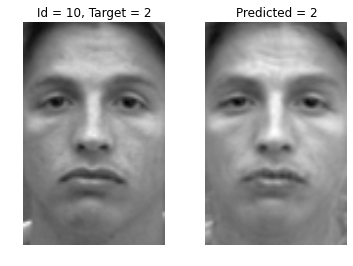

In [13]:
def plot_classification(n):
    net = trained_nets['net']
    f, axs = plt.subplots(1,2)
    axs[0].imshow(dataset.images[n],cmap='gray')
    axs[0].set_title('Id = %d, Target = %d' % (dataset.target[n], net.targets[n]))
    axs[0].axis('off')
    
    prediction, reconstruction = net.predict(n)
    axs[1].imshow(reconstruction.reshape(dataset.images.shape[1:]),cmap='gray')
    axs[1].set_title('Predicted = %d' % prediction)
    axs[1].axis('off')

interact(plot_classification, n=IntSliderWidget(max=dataset.images.shape[0]-1))